# Otro test 

Este notebook tiene como objetivo entrenar un SDAE y mostrar el Information Plane obtenido.

In [1]:
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

ipdl_dir = os.path.join(project_dir, "ipdl/")
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

In [2]:
import torch
from torch import tensor, Tensor
from torch import nn

from IPAE import SDAE, InformationPlane

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = SDAE([28*28, 1000, 500, 250, 32], dropout=True).to(device)
model = SDAE([28*28, 500, 500, 250, 10], dropout=False).to(device)

# Training

In [4]:
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.utils import save_image
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transformToTensor = Compose([
            ToTensor(), # first, convert image to PyTorch tensor
            Normalize((0.5,), (0.5,)),
            # Normalize((0.1307,), (0.3081,)), # normalize inputs
            Lambda(lambda x: torch.flatten(x)) # Auto-flatten
        ])

train_dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)

test_dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=False, download=False, transform=transformToTensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=0) 

model = model.to(device)

In [5]:
print(model)

SDAE(
  (sdae): Sequential(
    (0): MatrixEstimator()
    (1): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=784, out_features=500, bias=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): MatrixEstimator()
    )
    (2): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=500, out_features=500, bias=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): MatrixEstimator()
    )
    (3): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=500, out_features=250, bias=True)
      (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): MatrixEstimator()
    )
    (4): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=250,

## SDAE Training

In [6]:
n_epoch = 100
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.1)

model.train()

eval_inputs, _ = next(iter(test_loader))
eval_inputs = eval_inputs.to(device)

epoch_iterator = tqdm(
    range(n_epoch),
    leave=True,
    unit="epoch",
    postfix={"lss": "%.6f" % 0.0, "vls": "%.6f" % -1,},
)

ip = InformationPlane(model)

for epoch in epoch_iterator:
    for idx, (inputs, _) in enumerate(dataloader):
        inputs = inputs.flatten(1).to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, inputs)
        loss_value = float(loss.item())        
        loss.backward()

        optimizer.step()

        if idx % 25 == 0:
            with torch.no_grad():
                model.eval()
                outputs = model(eval_inputs.flatten(1))
                eval_loss_value = float((criterion(outputs, eval_inputs.flatten(1))).item())
                epoch_iterator.set_postfix(
                    lss="%.6f" % loss_value, vls="%.6f" % eval_loss_value,
                )
            model.train()
    
    scheduler.step()
    
    ip.calculate_mi()

 17%|█▋        | 17/100 [06:22<31:09, 22.53s/epoch, lss=0.207340, vls=0.188378]


KeyboardInterrupt: 

# Showing results

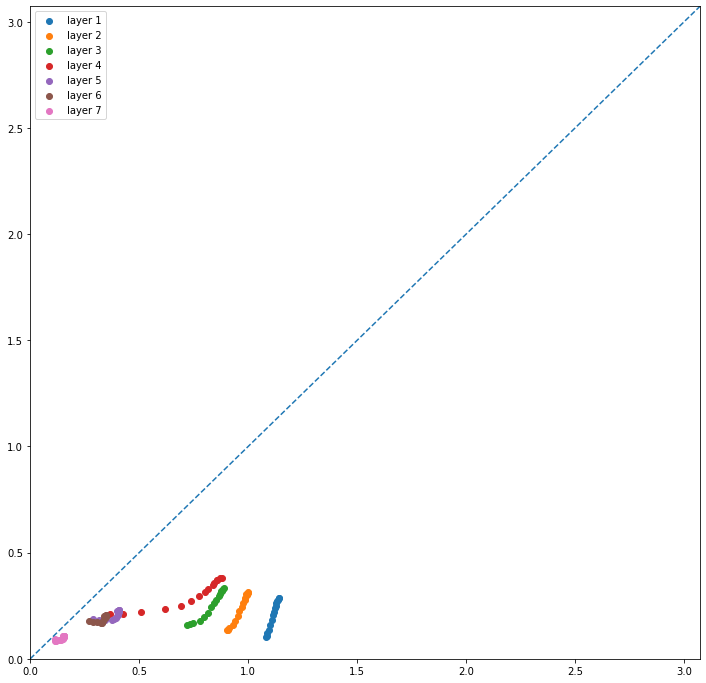

In [7]:
from matplotlib import pyplot as plt
from IPDL import MatrixBasedRenyisEntropy

f, ax = plt.subplots(figsize=(12, 12))
reference = MatrixBasedRenyisEntropy.entropy(ip.get_input_matrix()).cpu()
ax.set(xlim=(0, reference), ylim=(0, reference))

Ixt, Ity = ip.get_mi(moving_average_n=3)

for idx in range(len(Ixt)):
    current_Ixt = Ixt[idx]
    current_Ity = Ity[idx]
    ax.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed')
plt.legend()
f.show()

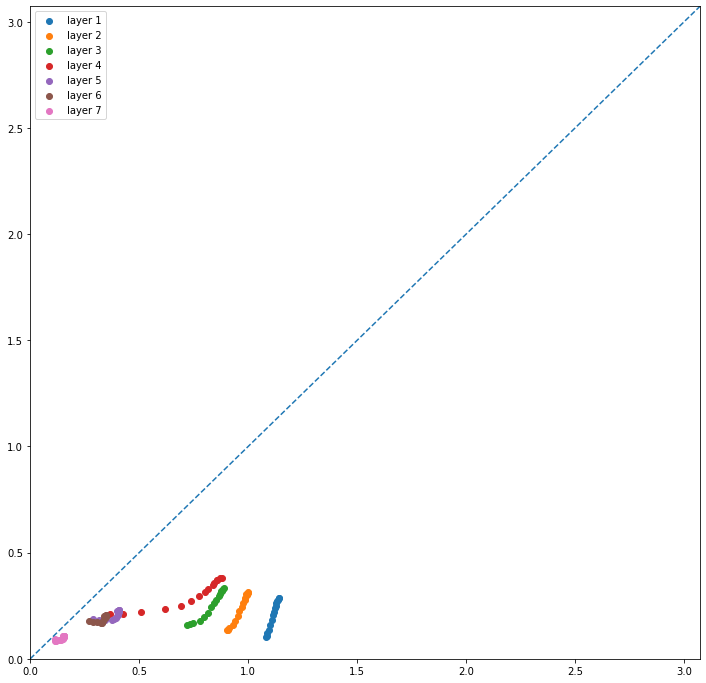

In [8]:
from matplotlib import pyplot as plt
from IPDL import MatrixBasedRenyisEntropy

f, ax = plt.subplots(figsize=(12, 12))
reference = MatrixBasedRenyisEntropy.entropy(ip.get_input_matrix()).cpu()
ax.set(xlim=(0, reference), ylim=(0, reference))

Ixt, Ity = ip.get_mi(moving_average_n=3)

for idx in range(len(Ixt)):
    current_Ixt = Ixt[idx]
    current_Ity = Ity[idx]
    ax.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed')
plt.legend()
f.show()

In [9]:
from IPAE import Utils

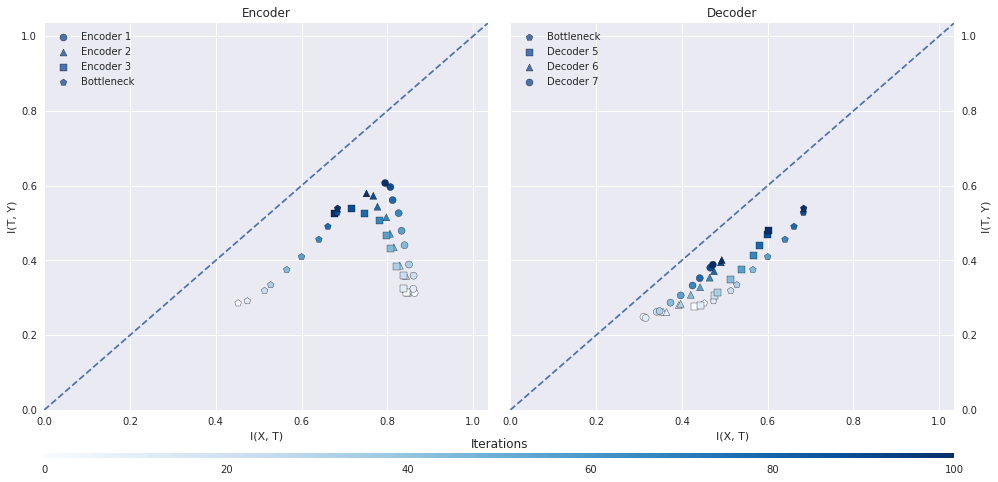

In [10]:
Utils.show_information_plane(ip).show()

# Result

In [9]:
from torchvision.utils import save_image

torch.cuda.empty_cache() 

def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x

with torch.no_grad():
    model.eval()
    outputs = model(eval_inputs)

print(outputs.shape)
print(eval_inputs.shape)

save_image(to_img(eval_inputs.cpu()), 'inputs.png')
save_image(to_img(outputs.cpu()), 'outputs.png')

torch.Size([512, 784])
torch.Size([512, 784])
